## Feature Selection 

In [1]:
from importlib import reload
import pandas as pd
import feature_selection as fs
reload(fs)

e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'feature_selection' from 'e:\\Ames-Housing-Price-Predictor\\notebooks\\feature_selection.py'>

### Load the dataset

In [2]:
df = pd.read_parquet("../data/processed/05_feature_engineering.parquet")

In [3]:
target = 'saleprice'
cat_features = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = fs.category_encoding(df, cat_features, target)

In [4]:
num_features = df_encoded.drop(columns = target).columns.tolist()

### Numerical Features -> Numerical Target

#### Correlation

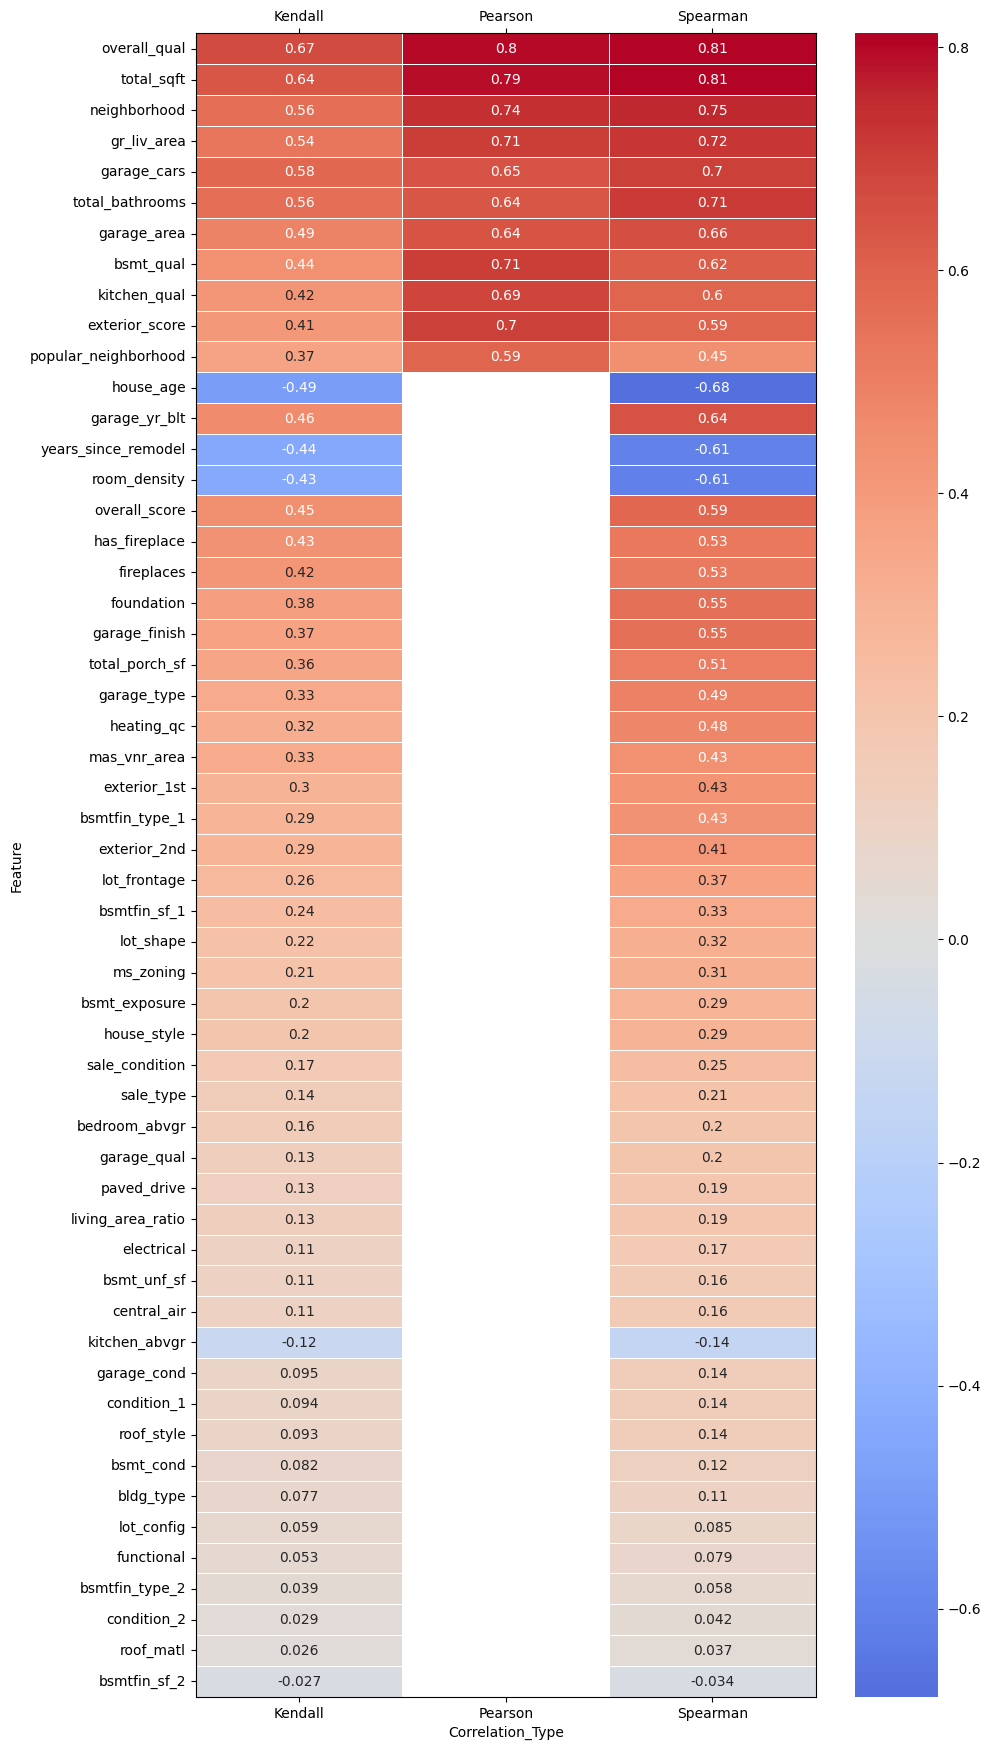

In [5]:
reload(fs)

corr_ranking = fs.correlation(
    df_encoded,
    num_features,
    target,
    soft=False,
    display_images=True,
)

#### Mutual Information Regression

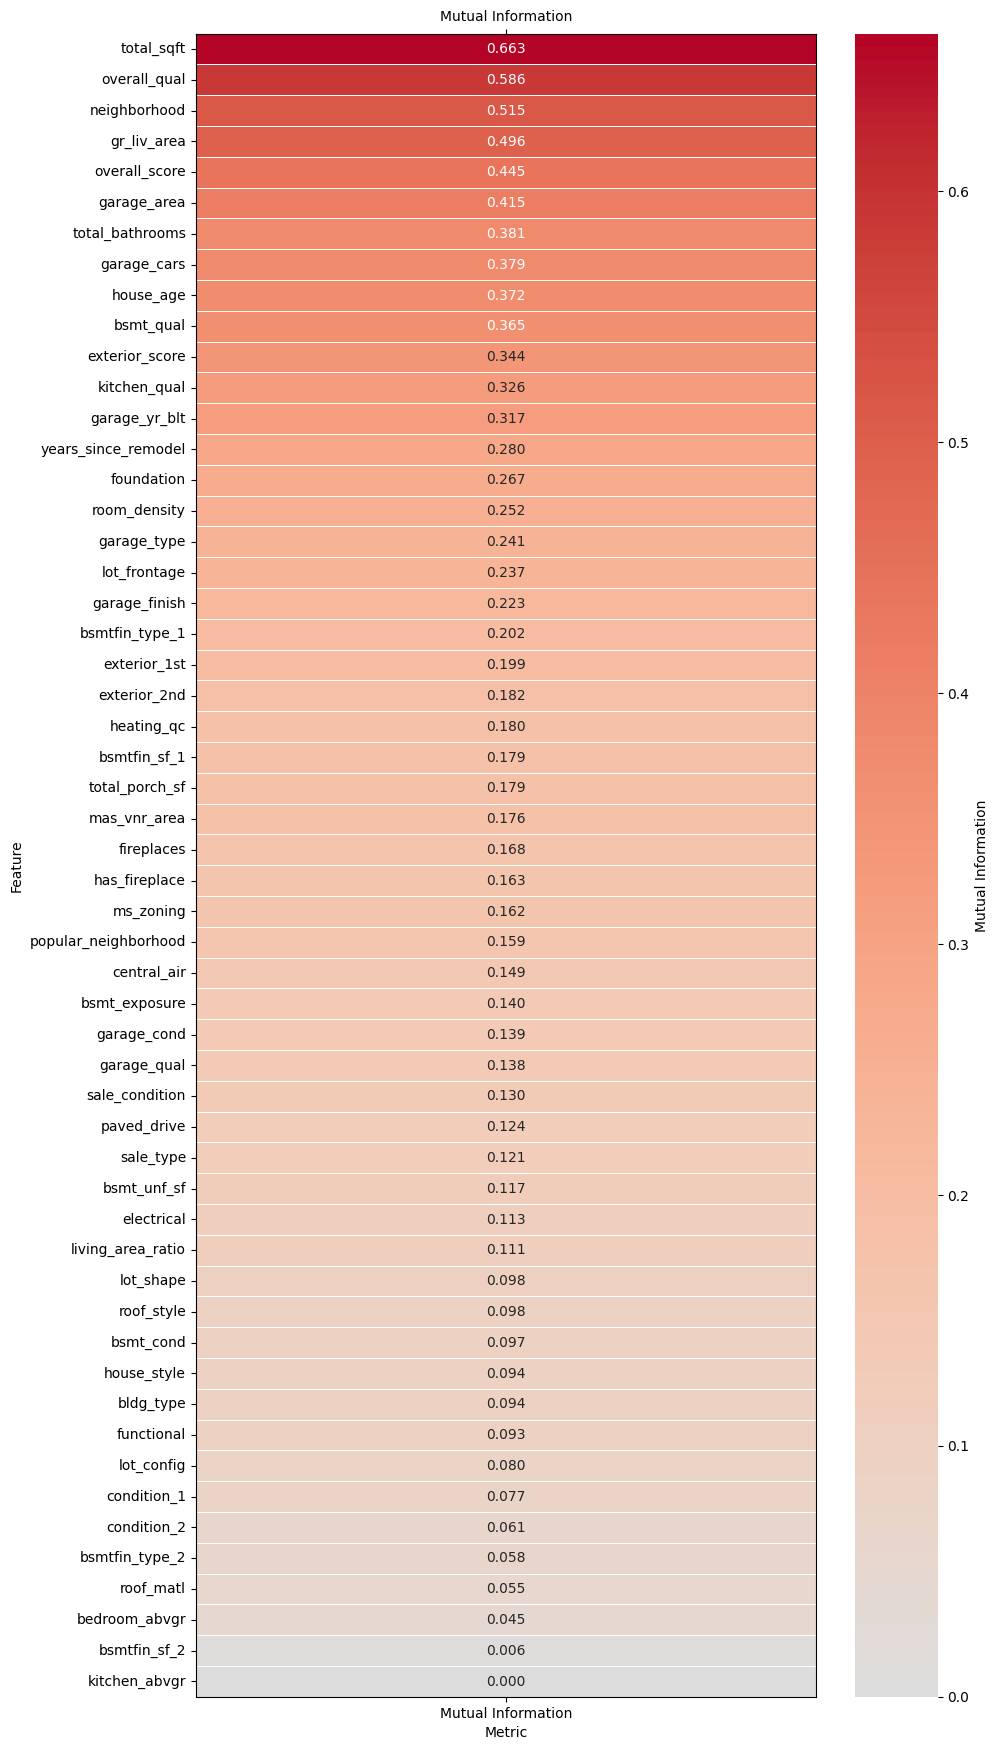

In [6]:
reload(fs)
mi_ranking = fs.mutual_information_reg(df_encoded, num_features, target, display_images=True)

#### Grid-Search for tree models -> Permutation Importance

In [7]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

regression_models = {
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(tree_method="hist", device="cuda"),
    "CatBoost": CatBoostRegressor(task_type="GPU", devices='0', verbose=0),
    "LightGBM": LGBMRegressor(device='gpu', verbose=-1)
}

regression_param_grids = {
    "RandomForest": {
        'n_estimators': [100, 150, 200, 250],
        'max_depth': [10, 20, 25, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
    },
    "XGBoost": {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [1, 1.5, 2]
    },
    "CatBoost": {
        'iterations': [100, 150, 200],
        'depth': [4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5, 7],
        'border_count': [32, 64, 128]
    },
    "LightGBM": {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [31, 40, 60],
        'max_depth': [-1, 10, 20],
        'min_child_samples': [5, 10, 20],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0, 0.5, 1]
    }
}

In [8]:
best_models = fs.random_search_regression(
    df_encoded,
    num_features,
    target,
    regression_models,
    regression_param_grids,
)

Training RandomForest...
Best parameters for RandomForest: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Training XGBoost...


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [15:30:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Best parameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Training CatBoost...
Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 150, 'depth': 6, 'border_count': 128}
Training LightGBM...
Best parameters for LightGBM: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.5, 'num_leaves': 40, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


,rmse,r2,mae
RandomForest,25713.470841,0.917533,15043.295725
XGBoost,22902.050997,0.934581,14062.801808
CatBoost,21910.590124,0.940122,14041.120274
LightGBM,23015.240276,0.933932,13771.100044


### Permutation importance

📂 Fold 1/2 — Modelo: RandomForest
📂 Fold 1/2 — Modelo: XGBoost
📂 Fold 1/2 — Modelo: CatBoost
📂 Fold 1/2 — Modelo: LightGBM


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


📂 Fold 2/2 — Modelo: RandomForest


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


📂 Fold 2/2 — Modelo: XGBoost
📂 Fold 2/2 — Modelo: CatBoost
📂 Fold 2/2 — Modelo: LightGBM


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


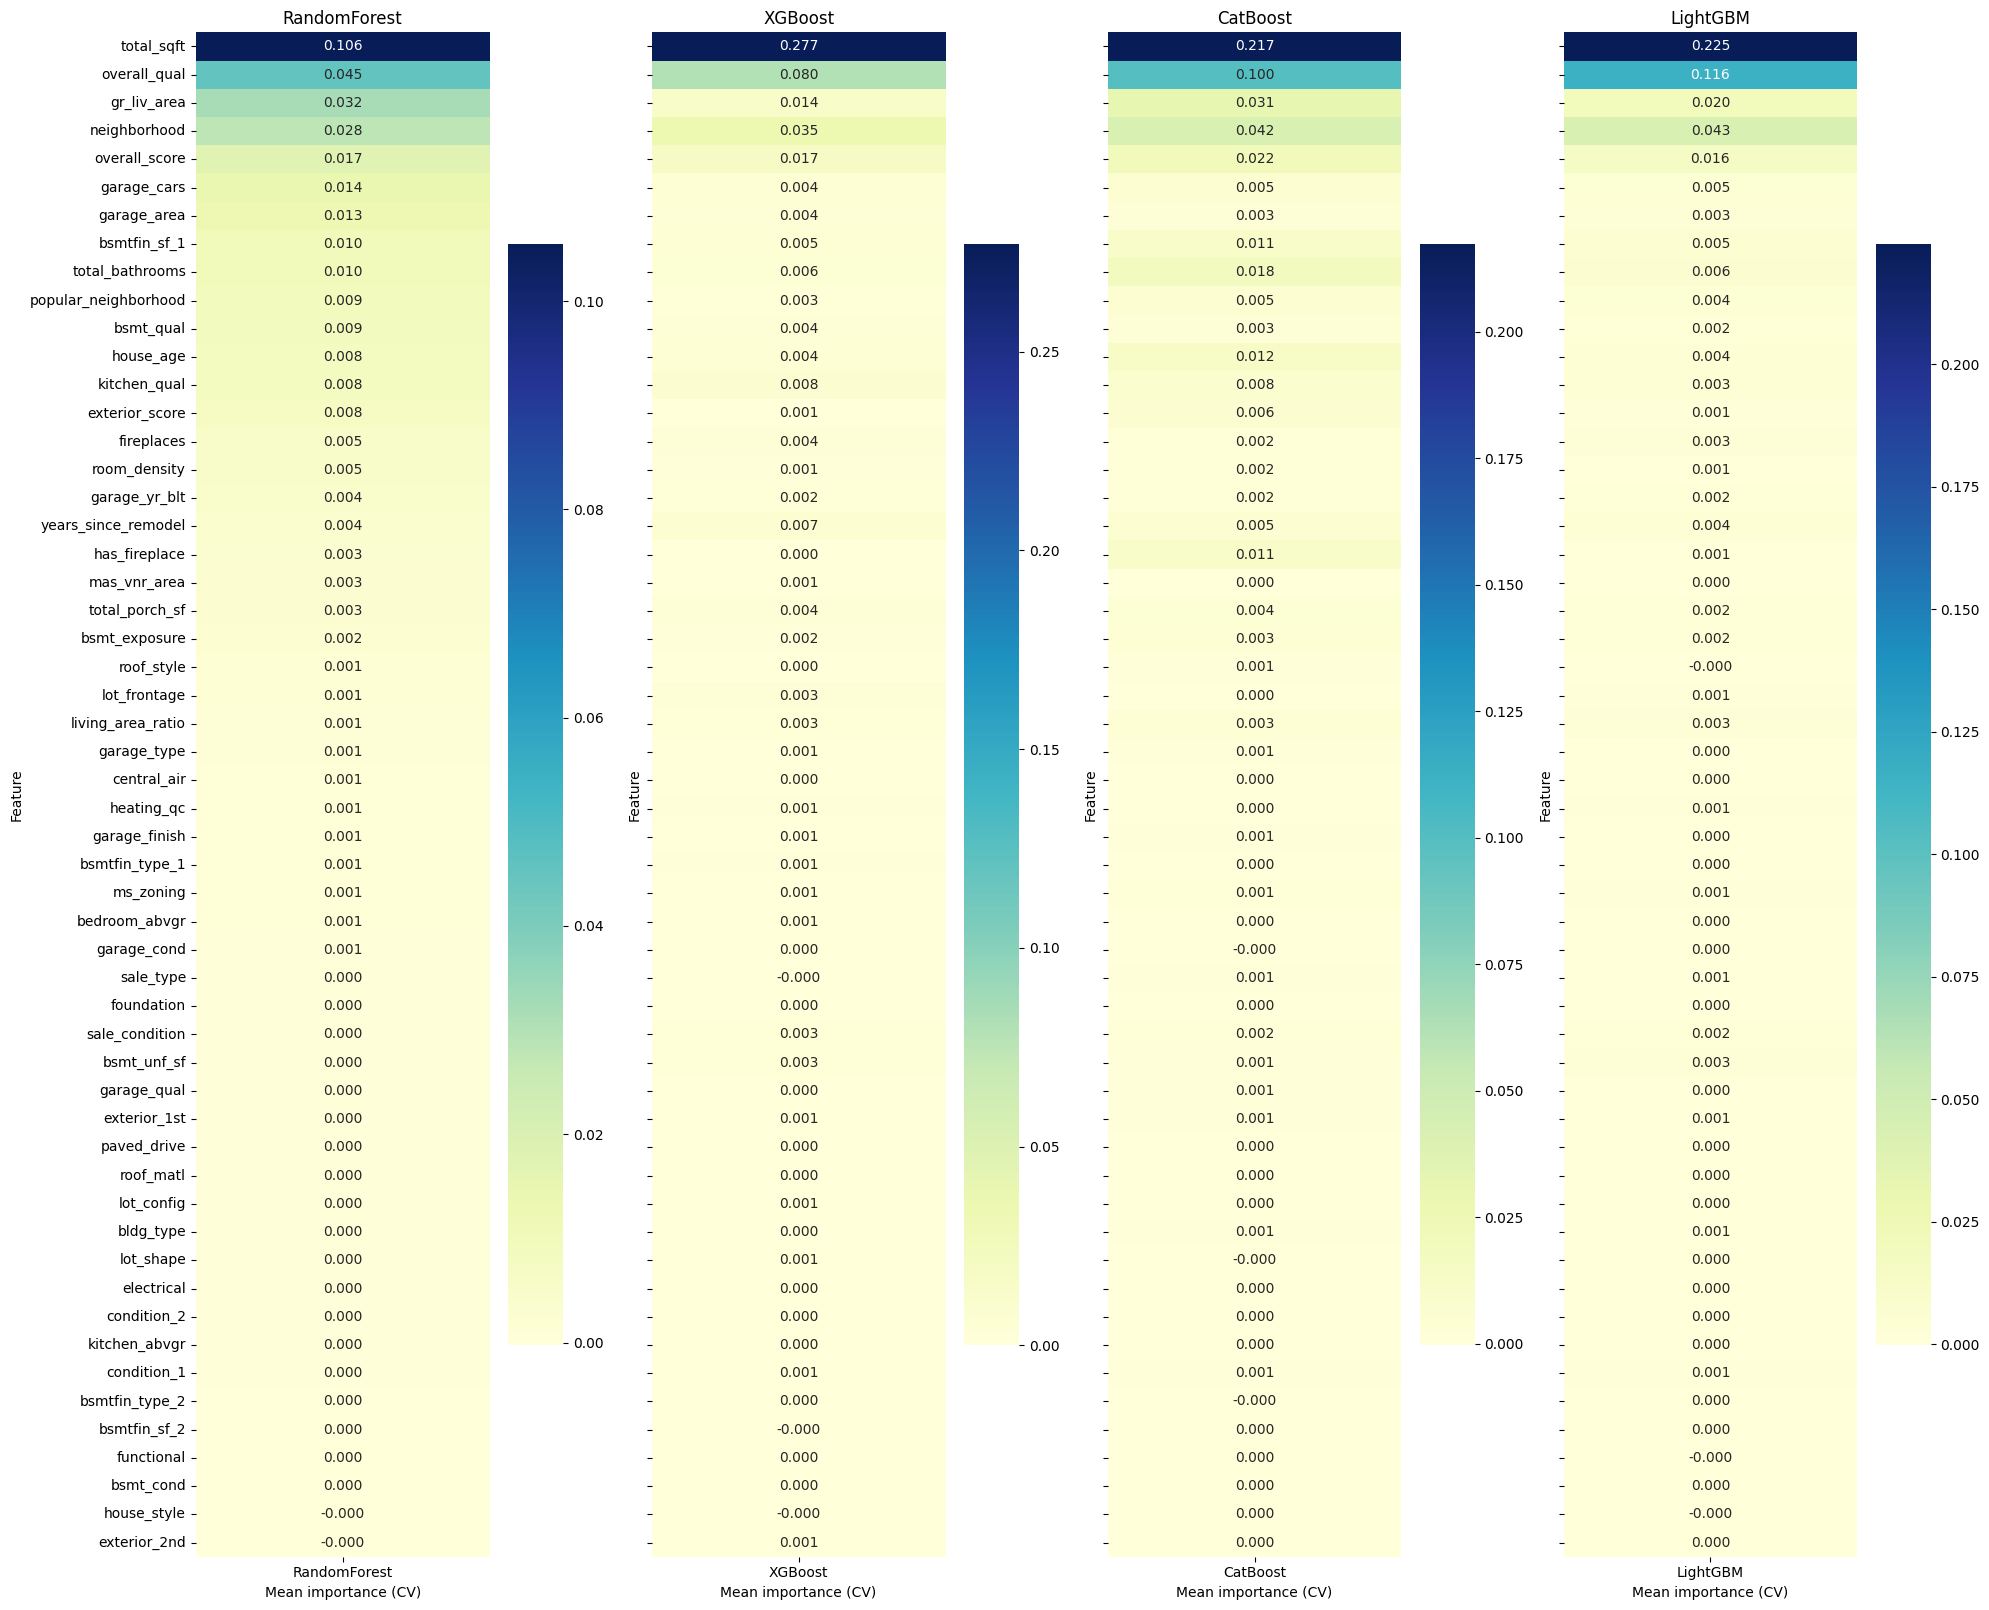

In [9]:
perm_ranking = fs.permutation_importanceCV(
    df_encoded,
    num_features,
    target,
    best_models,
    random_state=42,
    scoring='r2',
    n_splits=2,
    n_repeats=25
)

### Shap Importance

🔍 Entrenando modelo: RandomForest


 99%|===================| 297/300 [00:55<00:00]        

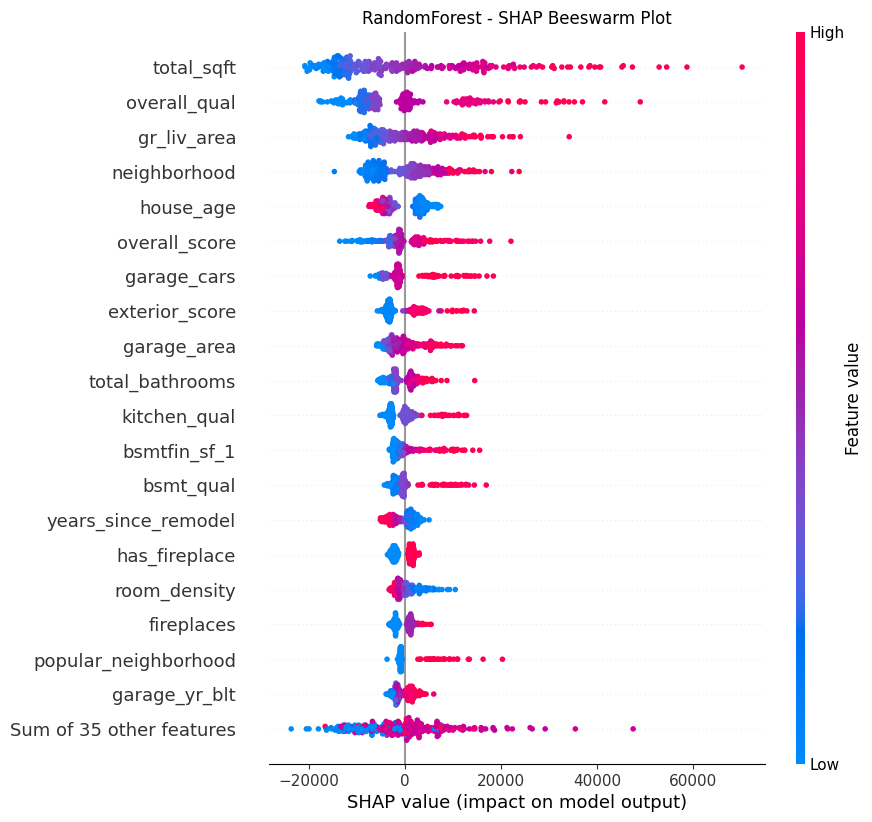

🔍 Entrenando modelo: XGBoost


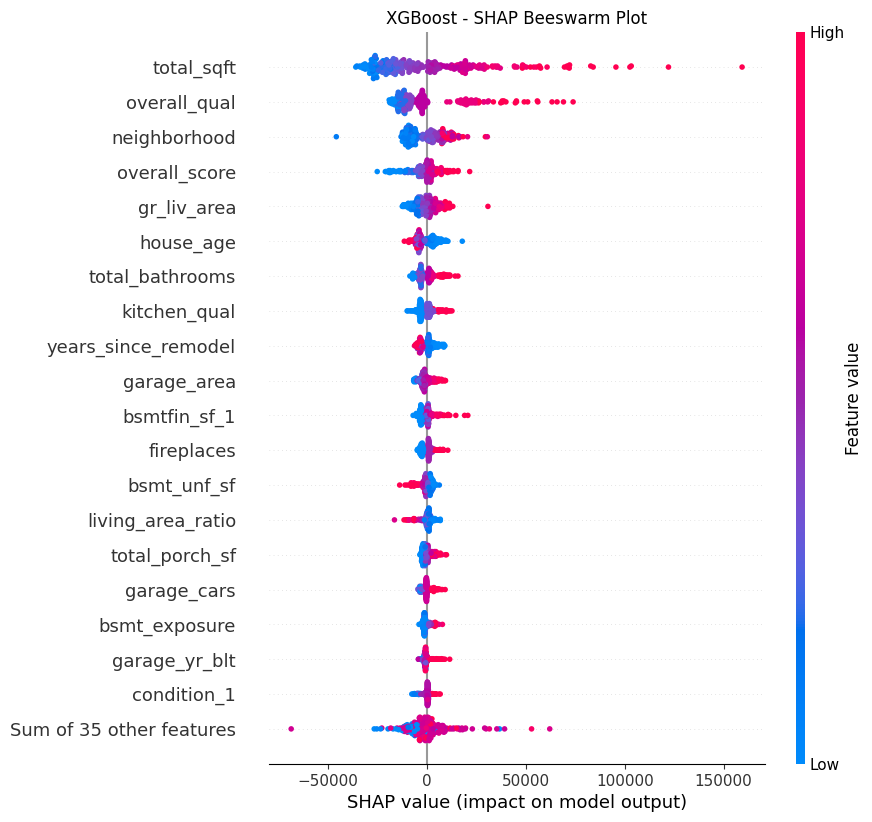

🔍 Entrenando modelo: CatBoost


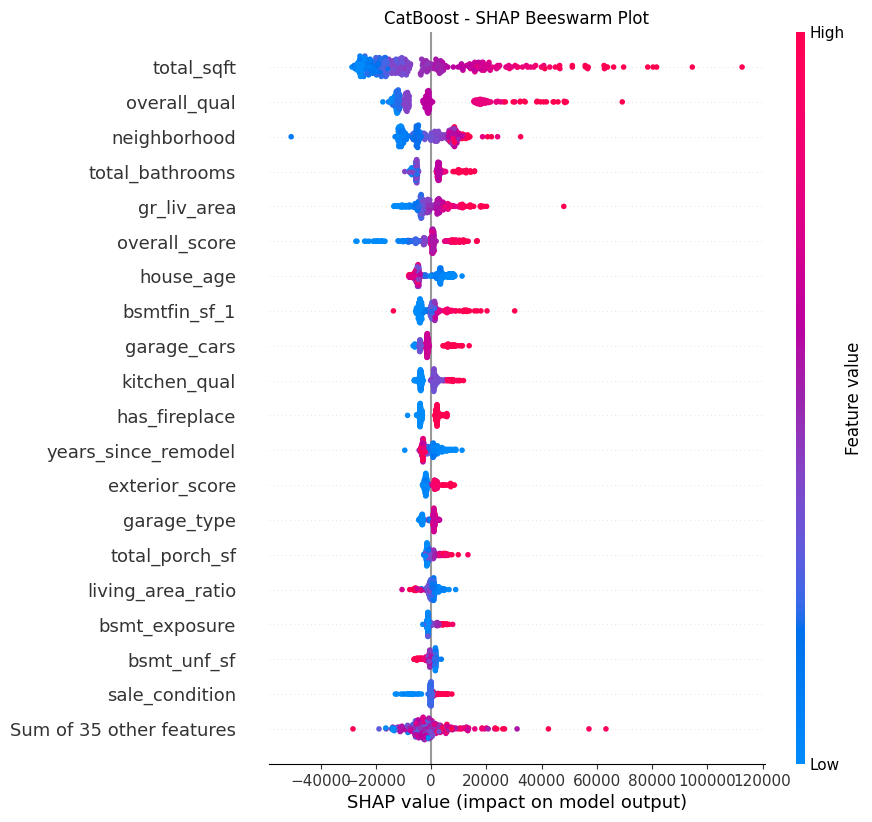

In [10]:
reload(fs)
shap_ranking = fs.shap_importance(
    models={"RandomForest": best_models["RandomForest"],
            "XGBoost": best_models["XGBoost"],
            "CatBoost": best_models["CatBoost"],},
    X=df_encoded[num_features],
    y=df_encoded[target],
    n_sample=300,
    top_n=20,
    random_state=42,
)

### Ranking Conclusion

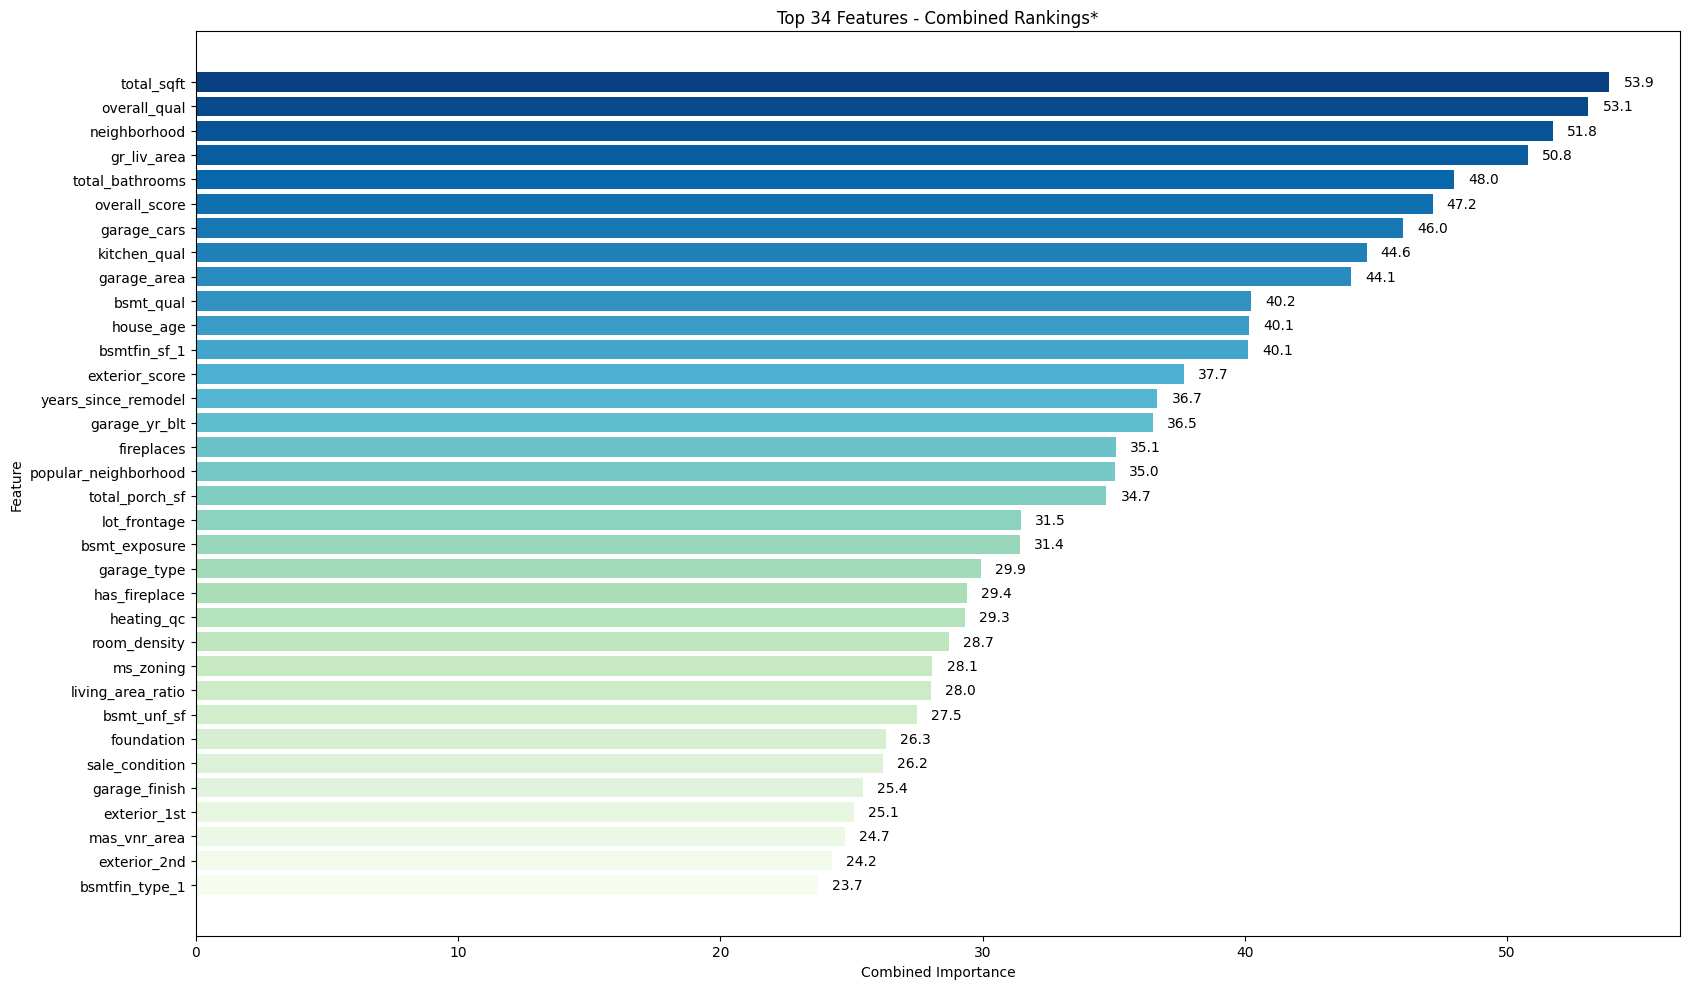

In [29]:
reload(fs)
selected_columns = fs.plot_feature_importance(
    shap_ranking,
    perm_ranking,
    corr_ranking,
    mi_ranking,
    top_n = 34
)

In [30]:
df_final = df_encoded[selected_columns + [target]]

In [31]:
df_final.to_parquet(
    "../data/processed/06_feature_selection.parquet",
    index=False,
)